In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, HuberRegressor
import pickle
import itertools
import time
import ot
import os
from scipy.stats import rankdata, spearmanr
import seaborn as sns
from datetime import datetime

In [2]:
plt.style.use('seaborn-whitegrid')

In [3]:
log_dir = './exec_logs'
cali_dir = './exec_cali'

In [4]:
with open('D:/GitHub/TITrans/old_data/gvkeysp500.txt', 'r') as fp:
    sp500_gv = fp.readlines()
#     print('Total Number of lines:', lines)

In [5]:
sp_gv = [int(line.rstrip('\n')) for line in sp500_gv]

In [6]:
merged = pd.read_csv('./exec_logs/classified_group_6.csv')

In [7]:
orig_ceo = pd.read_csv('./ceo_y17.csv')

In [10]:
np.savetxt('790firms_gvkey.txt', merged['gvkey'].unique(), fmt='%s')  

## CEO Tenure

In [ ]:
firm_kept = merged['gvkey'].unique()

In [ ]:
ceo_sub = orig_ceo[orig_ceo['GVKEY'].isin(firm_kept)]
ceo_sub = ceo_sub[~ceo_sub['BECAMECEO'].isnull()]
ceo_sub = ceo_sub.reset_index(drop=True)

In [ ]:
ceo_sub

In [ ]:
n_obs = ceo_sub.shape[0]

In [ ]:
for idx in range(n_obs):
    ceo_sub.loc[idx, 'Tenure'] = ceo_sub.loc[idx, 'YEAR'] - int(ceo_sub.loc[idx, 'BECAMECEO']/10000)
    gv = ceo_sub.loc[idx, 'GVKEY']
    gsec_ = merged[merged['gvkey'] == gv]['gsector'].unique()[0]
    ceo_sub.loc[idx, 'gsector'] = gsec_

In [ ]:
ceo_sub['Tenure'].median(), ceo_sub['Tenure'].mean()

In [ ]:
med_tenure = ceo_sub.groupby(['gsector'])['Tenure'].mean()

### Number of firms

In [ ]:
merged.groupby(['gsector'])['gvkey'].nunique()

In [ ]:
gv_merged = merged['gvkey'].unique()
len(gv_merged)

In [ ]:
len(set(sp_gv) - set(gv_merged))

In [ ]:
len(sp_gv) - 103

### Statistics 

In [ ]:
merged.groupby(['gsector'])['mkvalt'].mean()

In [ ]:
finstat = pd.read_csv('./finstat_y17.csv')

In [ ]:
finstat[finstat['fyear'] == 2021]['mkvalt'].sum()

In [ ]:
merged[merged['year'] == 2021]['mkvalt'].sum()

In [ ]:
np.round(merged.groupby(['gsector'])['mkvalt'].mean().values, 2)

In [ ]:
np.round(merged.groupby(['gsector'])['sale'].mean().values, 2)

In [ ]:
np.round(merged.groupby(['gsector'])['tdc1'].mean().values, 2)

In [ ]:
merged[['mkvalt', 'sale', 'tdc1']].corr(method='spearman')

### Testing Roberts law across sectors

In [9]:
gs = merged['gsector'].unique()
gs = np.sort(gs)
gs

array([10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.])

In [ ]:
rho_arr = np.zeros(11)
spearman_arr = np.zeros(11)
kendall_arr = np.zeros(11)
for k in range(11):
    rho_arr[k] = merged[merged['gsector'] == gs[k]][['tdc1', 'sale']].corr(method='pearson').iloc[0, 1]
    spearman_arr[k] = merged[merged['gsector'] == gs[k]][['tdc1', 'sale']].corr(method='spearman').iloc[0, 1]
    kendall_arr[k] = merged[merged['gsector'] == gs[k]][['tdc1', 'sale']].corr(method='kendall').iloc[0, 1]
    print(rho_arr[k], gs[k])

In [ ]:
spearmanr(spearman_arr, med_tenure.values)

In [ ]:
spearman_arr

In [ ]:
med_tenure

In [ ]:
np.round(spearman_arr, 3)

In [ ]:
np.round(kendall_arr, 3)

In [ ]:
with open('{}/even_spearman_list.pickle'.format(log_dir), 'rb') as fp:
    s_corr = pickle.load(fp)

with open('{}/even_kendall_list.pickle'.format(log_dir), 'rb') as fp:
    k_corr = pickle.load(fp)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 20, 1), s_corr, 'o', label='Spearman')
plt.plot(np.arange(2, 20, 1), k_corr, '*', label='Kendall')
plt.xticks(np.arange(2, 20, 1))
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.savefig('even_split.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [ ]:
with open('{}/uneven_spearman_list.pickle'.format(log_dir), 'rb') as fp:
    un_s_corr = pickle.load(fp)

with open('{}/uneven_kendall_list.pickle'.format(log_dir), 'rb') as fp:
    un_k_corr = pickle.load(fp)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(2, 20, 1), un_s_corr, 'o', label='Spearman')
plt.plot(np.arange(2, 20, 1), un_k_corr, '*', label='Kendall')
plt.xticks(np.arange(2, 20, 1))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Number of clusters', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.savefig('uneven_split.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

## Transition matrix

15.0


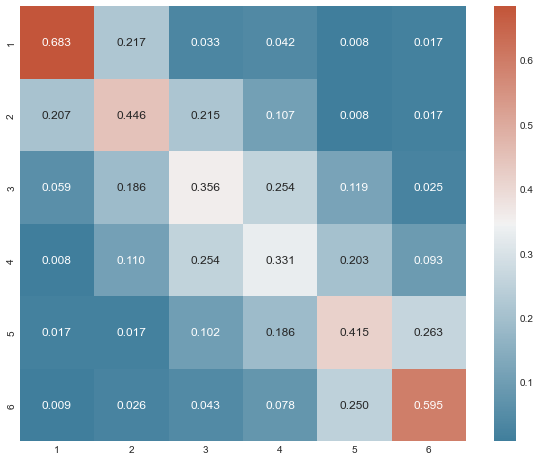

In [36]:
gs_idx = 1
w_file_name = "wage_trans_gs_{}.pickle".format(int(gs[gs_idx]))
print(gs[gs_idx])
with open('{}/{}'.format(log_dir, w_file_name), 'rb') as fp:
    wage_trans = pickle.load(fp)
for row in range(6):
    wage_trans[row, :] = wage_trans[row, :]/wage_trans[row, :].sum()
x_shape = wage_trans.shape[0]
        
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(wage_trans, xticklabels=np.arange(1, x_shape+1),
                 yticklabels=np.arange(1, x_shape+1),
                 annot=True, fmt=".3f", annot_kws={"fontsize": 12}, cmap=cmap)

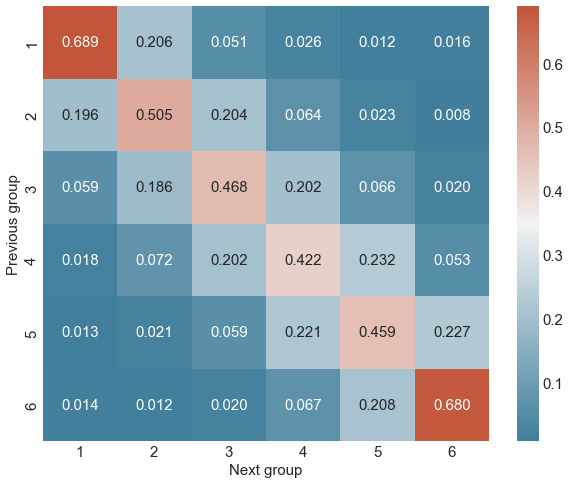

In [29]:
x_shape = 6
wage_agg = np.zeros((6, 6))
for gs_idx in range(11):
    w_file_name = "wage_trans_gs_{}.pickle".format(int(gs[gs_idx]))
#     print(gs[gs_idx])
    with open('{}/{}'.format(log_dir, w_file_name), 'rb') as fp:
        wage_trans = pickle.load(fp)
    for row in range(6):
        wage_trans[row, :] = wage_trans[row, :]/wage_trans[row, :].sum()
    wage_agg += wage_trans 

wage_agg = wage_agg/11        
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(wage_agg, xticklabels=np.arange(1, x_shape+1),
                 yticklabels=np.arange(1, x_shape+1),
                 annot=True, fmt=".3f", annot_kws={"fontsize": 15}, cmap=cmap)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Next group', fontsize=15)
plt.ylabel('Previous group', fontsize=15)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
# plt.legend(loc='best', fontsize=15)
# plt.savefig('sale_trans.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)